In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime
import warnings
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
from scipy import stats

In [2]:
def get_clean_data(df_original):
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'V', 'I')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    df = df[df.index < '2017']
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    
    return clean_df

### Secondary band price

In [3]:
raw_band_price = pd.read_csv('export_PrecioBandaDeRegulaciónSecundaria_2017-01-15_19-11.csv', encoding='latin1', delimiter=';')

In [4]:
band_price = get_clean_data(raw_band_price)

In [5]:
band_price.index

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00', '2014-01-01 05:00:00',
               '2014-01-01 06:00:00', '2014-01-01 07:00:00',
               '2014-01-01 08:00:00', '2014-01-01 09:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date_hour', length=26304, freq=None)

In [7]:
#Mean price
year_weekday_hour_band_price = band_price[['year', 'season', 'weekday', 'hour', 'value']].groupby(['year', 'season', 'weekday', 'hour']).mean().unstack(-1)
year_weekday_hour_band_price.columns = year_weekday_hour_band_price.columns.droplevel(0)

#Hourly mean
mean_timely = band_price[['time', 'value']].groupby('time').mean()

In [6]:
#Std price
year_weekday_hour_band_price_std = band_price[['year', 'season', 'weekday', 'hour', 'value']].groupby(['year', 'season', 'weekday', 'hour']).std().unstack(-1)
year_weekday_hour_band_price_std.columns = year_weekday_hour_band_price_std.columns.droplevel(0)

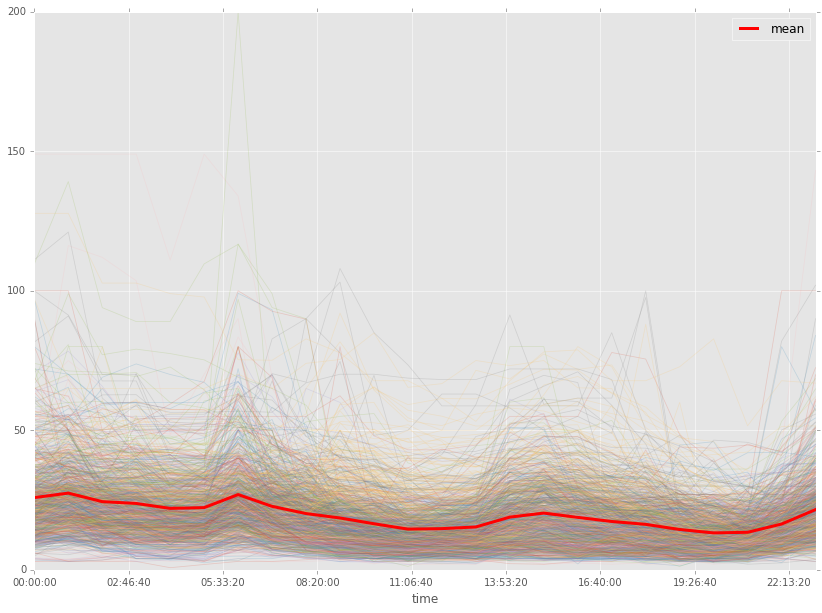

In [9]:
fig, axis = plt.subplots(1,1, figsize=(14,10))
#Plot for each day, the 24 hour period
band_price.groupby(['time', 'date'])[['value']].sum().unstack(-1).plot(ax=axis, legend=False, alpha=0.2, lw=0.75)
# #Plot the mean of all paths
mean_timely.rename(columns={'value':'mean'}).plot(ax=axis, lw=3.0, legend=True, color='red');
# #axis.legend(loc=0)

### Find a relation between secondary band price and other measures

###### Band requirements

In [7]:
raw_band_req= pd.read_csv('export_RequerimientosBandaDeRegulaciónSecundariaABajar_2017-02-02_09-11.csv', encoding='latin1', delimiter=';')

In [8]:
band_req = get_clean_data(raw_band_req)

In [9]:
band_price_req = band_price[['value']].merge(band_req[['value']], how='left', left_index=True, right_index=True)
band_price_req.columns = ['price', 'req']

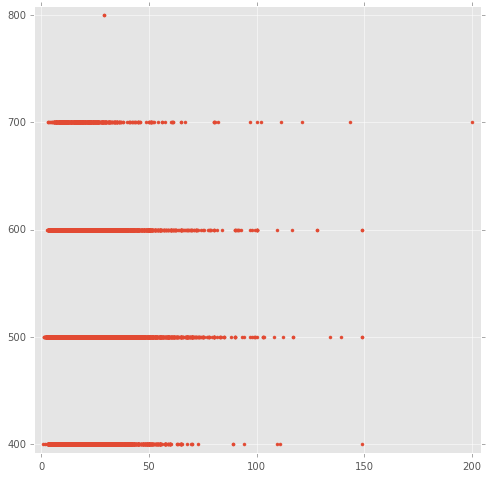

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(band_price_req['price'], band_price_req['req'], marker='.', linestyle='none'),
ax.margins(0.02)

##### Band allocation

In [11]:
raw_band_allocation = pd.read_csv('export_AsignaciónBandaDeRegulaciónSecundariaABajar_2017-02-02_09-15.csv', encoding='latin1', delimiter=';')

In [12]:
band_allocation = get_clean_data(raw_band_allocation)

In [13]:
band_price_allocation = band_price[['value']].merge(band_allocation[['value']], how='left', left_index=True, right_index=True)
band_price_allocation.columns = ['price', 'allocation']

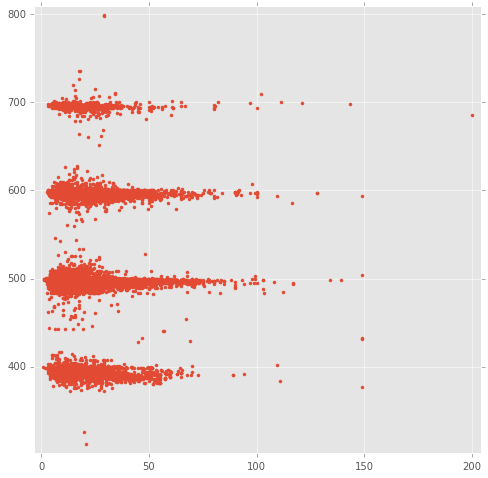

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(band_price_allocation['price'], band_price_allocation['allocation'], marker='.', linestyle='none'),
ax.margins(0.02)

##### Programmed demand

In [15]:
raw_demand_prog = pd.read_csv('export_DemandaProgramada_2017-02-02_09-45.csv', encoding='latin1', delimiter=';')

In [16]:
demand_prog = get_clean_data(raw_demand_prog)

In [17]:
band_price_deman_prog = band_price[['value']].merge(demand_prog[['value']], how='left', left_index=True, right_index=True)
band_price_deman_prog.columns = ['price', 'demand']

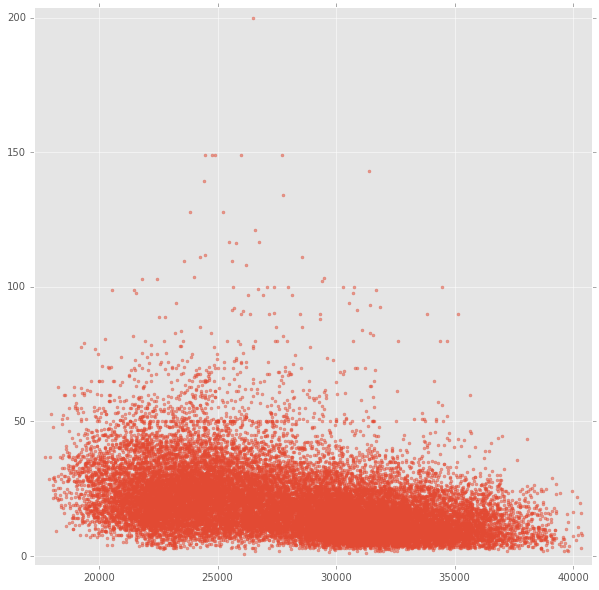

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(band_price_deman_prog['demand'], band_price_deman_prog['price'], marker='.', linestyle='none', alpha=0.5)
ax.margins(0.02);

In [19]:
np.corrcoef(band_price_deman_prog.values.T)

array([[ 1.        , -0.40300454],
       [-0.40300454,  1.        ]])

##### Spot price DAM

In [11]:
raw_spot_price = pd.read_csv('export_PrecioMercadoSPOTDiario_2017-02-02_09-47.csv', encoding='latin1', delimiter=';')

In [12]:
raw_spot_price = raw_spot_price[raw_spot_price['geoid'] == 3]

In [13]:
spot_price = get_clean_data(raw_spot_price)

In [14]:
mean_spot_price = spot_price[['time', 'value']].groupby('time').mean()

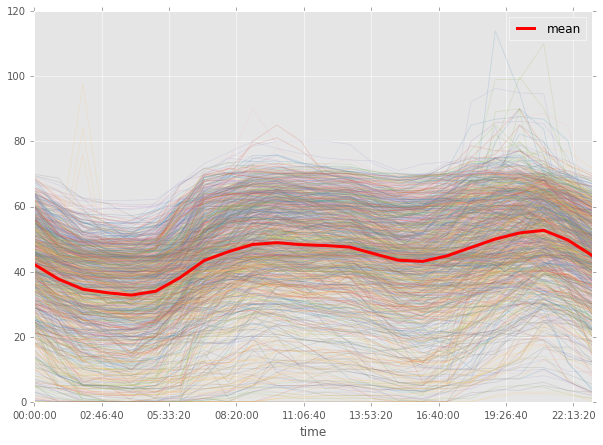

In [15]:
fig, axis = plt.subplots(1,1, figsize=(10,7))
#Plot for each day, the 24 hour period
spot_price.groupby(['time', 'date'])[['value']].sum().unstack(-1).plot(ax=axis, legend=False, alpha=0.2, lw=0.75)
# #Plot the mean of all paths
mean_spot_price.rename(columns={'value':'mean'}).plot(ax=axis, lw=3.0, legend=True, color='red');

In [23]:
band_spot_price = band_price[['value']].merge(spot_price[['value']], how='left', left_index=True, right_index=True)
band_spot_price.columns = ['band', 'spot']

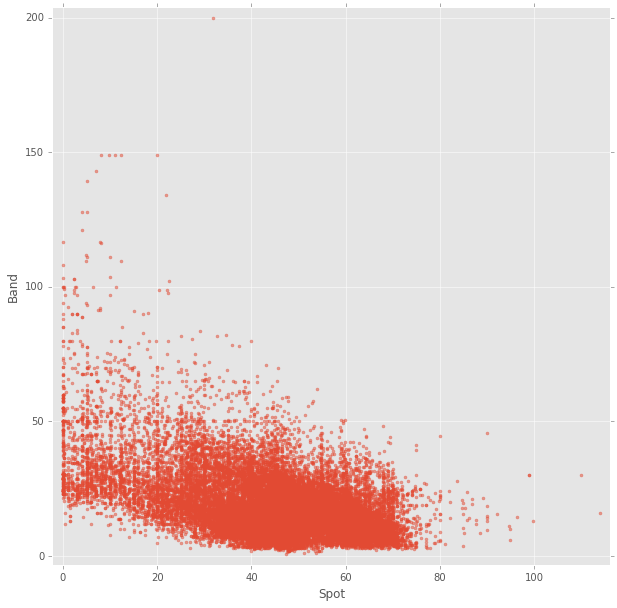

In [24]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(band_spot_price['spot'], band_spot_price['band'], marker='.', linestyle='none', alpha=0.5)
ax.set_xlabel('Spot')
ax.set_ylabel('Band')
ax.margins(0.02);

In [25]:
band_spot_price_scaled = (band_spot_price - band_spot_price.mean()) / band_spot_price.std()

In [26]:
np.corrcoef(band_spot_price.values.T)

array([[ 1.        , -0.48185622],
       [-0.48185622,  1.        ]])

In [27]:
band_price.head()

date  year  month season  day  weekday      time  \
date_hour                                                                    
2014-01-01 00:00:00 2014-01-01  2014      1      I    1        2  00:00:00   
2014-01-01 01:00:00 2014-01-01  2014      1      I    1        2  01:00:00   
2014-01-01 02:00:00 2014-01-01  2014      1      I    1        2  02:00:00   
2014-01-01 03:00:00 2014-01-01  2014      1      I    1        2  03:00:00   
2014-01-01 04:00:00 2014-01-01  2014      1      I    1        2  04:00:00   

                     hour  minute  value  
date_hour                                 
2014-01-01 00:00:00     0       0  69.01  
2014-01-01 01:00:00     1       0  50.00  
2014-01-01 02:00:00     2       0  57.80  
2014-01-01 03:00:00     3       0  54.15  
2014-01-01 04:00:00     4       0  54.15

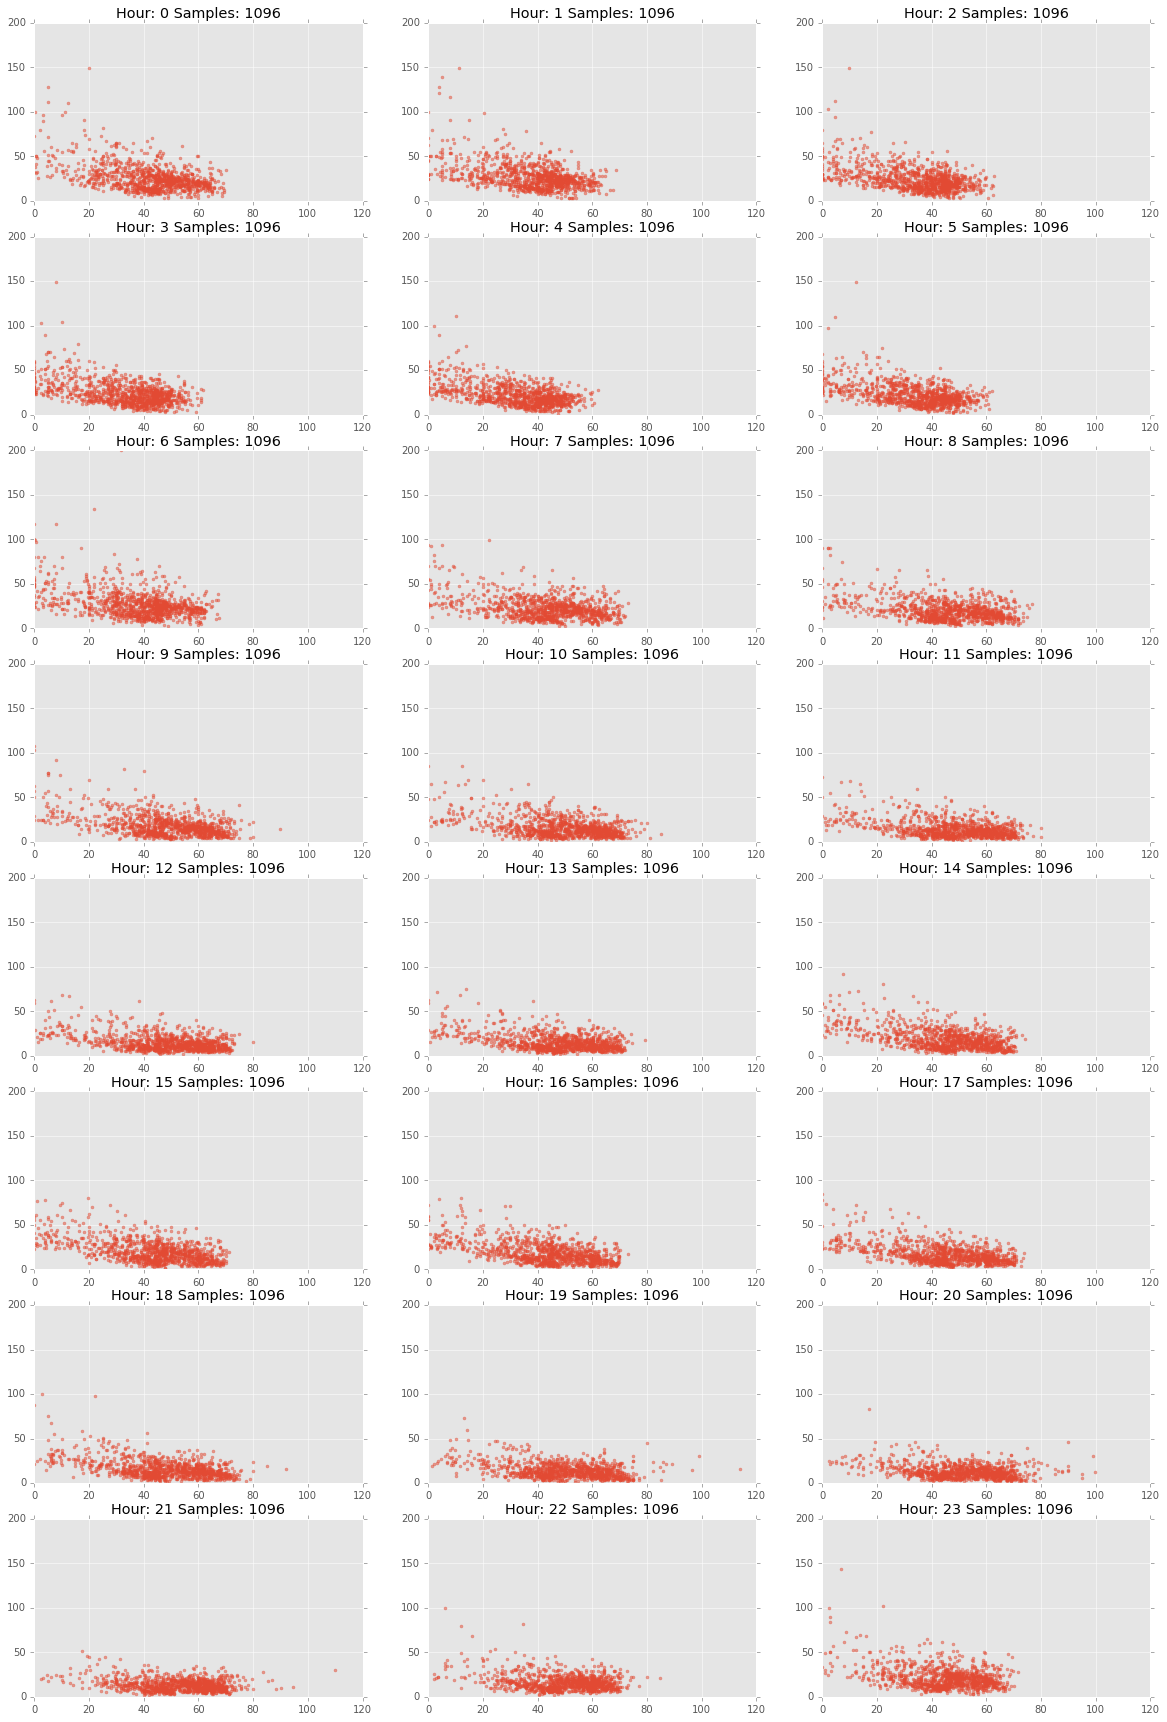

In [28]:
fig, ax = plt.subplots(8,3, figsize=(20,30))
axis =[]
for element in ax:
    axis.append(element)
for hour in range(0,24):
    axis[int(hour/3)][hour%3].plot(spot_price[spot_price['hour'] == hour]['value'], band_price[band_price['hour'] == hour]['value'], 
            marker='.', linestyle='none', alpha=0.5)
    axis[int(hour/3)][hour%3].set_title('Hour: ' +str(hour) + ' Samples: ' + str(len(spot_price[spot_price['hour'] == hour]['value'])))
    axis[int(hour/3)][hour%3].set_xlim(0, 120)
    axis[int(hour/3)][hour%3].set_ylim(0, 200)
    axis[int(hour/3)][hour%3].margins(0.03)

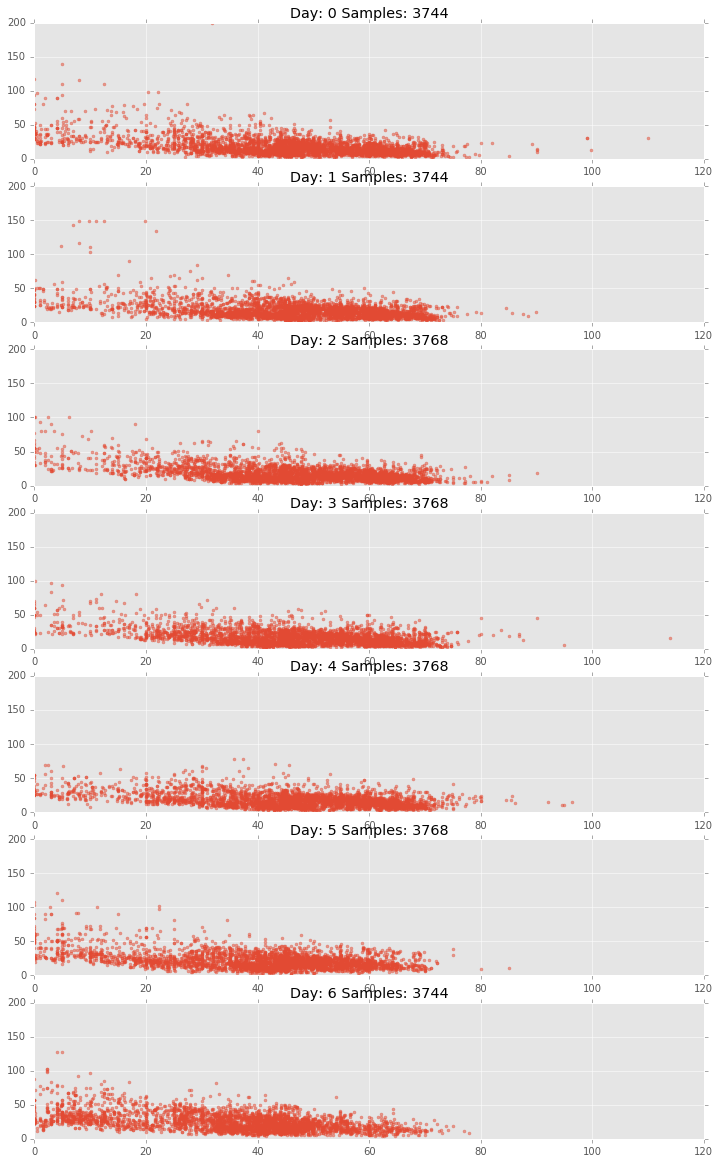

In [29]:
fig, ax = plt.subplots(7,1, figsize=(12,20))
axis =[]
for element in ax:
    axis.append(element)
for day in range(0,7):
    axis[day].plot(spot_price[spot_price['weekday'] == day]['value'], band_price[band_price['weekday'] == day]['value'], 
            marker='.', linestyle='none', alpha=0.5)
    axis[day].set_title('Day: ' +str(day) + ' Samples: ' + str(len(spot_price[spot_price['weekday'] == day]['value'])))
    axis[day].set_xlim(0, 120)
    axis[day].set_ylim(0, 200)
    axis[day].margins(0.03)

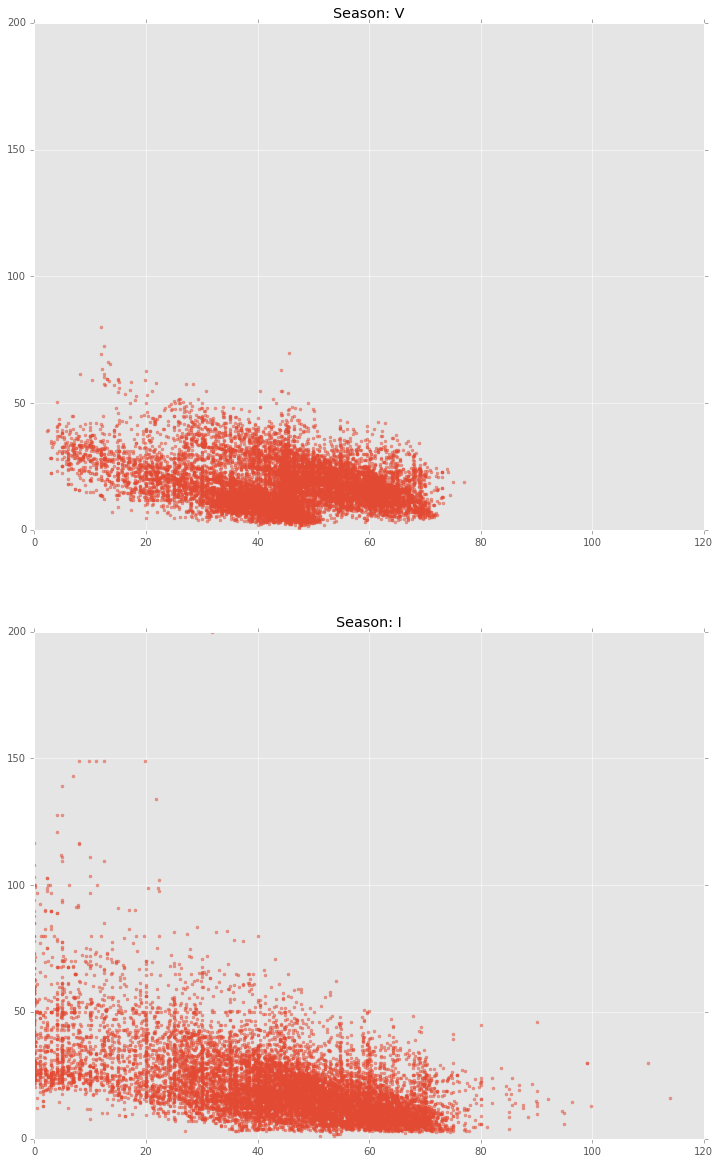

In [30]:
fig, ax = plt.subplots(2,1, figsize=(12,20))
axis =[]
for element in ax:
    axis.append(element)
for index, season in zip([0,1], ['V', 'I']):
    axis[index].plot(spot_price[spot_price['season'] == season]['value'], band_price[band_price['season'] == season]['value'], 
            marker='.', linestyle='none', alpha=0.5)
    axis[index].set_title('Season: ' + season)
    axis[index].set_xlim(0, 120)
    axis[index].set_ylim(0, 200)
    axis[index].margins(0.03)

In [ ]:
#Split spot and reserve price by conditions in order to observe potential relationships
#First split by hour
fig, ax = plt.subplots(1,1, figsize=(7,7))
axis = [element for element in ax]

for hour in range(0,24):
    ax.plot(spot_price[spot_price['hour'] == hour]['value'], band_price[band_price['hour'] == hour]['value'], 
            marker='.', linestyle='none', alpha=0.5)
    ax.set_title('Hour: ' +str(hour))

##### Energy allocated on DAM

In [31]:
raw_energy_dam = pd.read_csv('export_EnergíaAsignadaEnMercadoSPOTDiarioEspaña_2017-02-02_09-28.csv', encoding='latin1', delimiter=';')

In [32]:
energy_dam = get_clean_data(raw_energy_dam)

In [33]:
band_price_energy_spot = band_price[['value']].merge(energy_dam[['value']], how='left', left_index=True, right_index=True)
band_price_energy_spot.columns = ['band', 'energy']

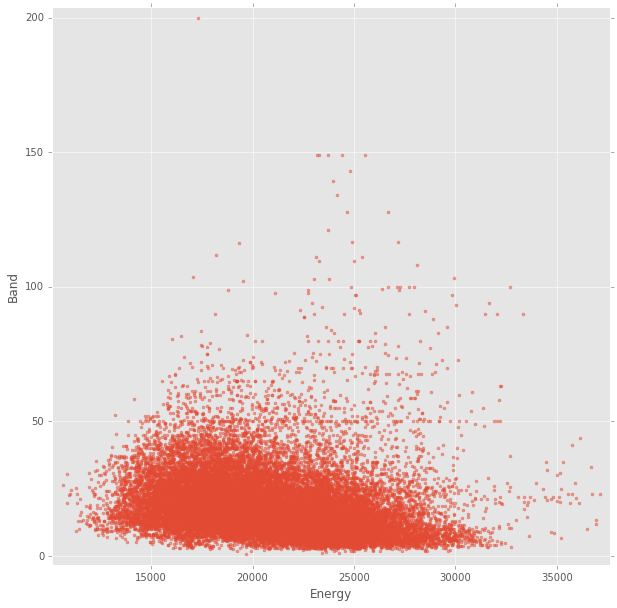

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot(band_price_energy_spot['energy'], band_price_energy_spot['band'], marker='.', linestyle='none', alpha=0.5)
ax.set_xlabel('Energy')
ax.set_ylabel('Band')
ax.margins(0.02);

In [35]:
np.corrcoef(band_price_energy_spot.values.T)

array([[ 1.       , -0.2125898],
       [-0.2125898,  1.       ]])

### Year TS and log scale

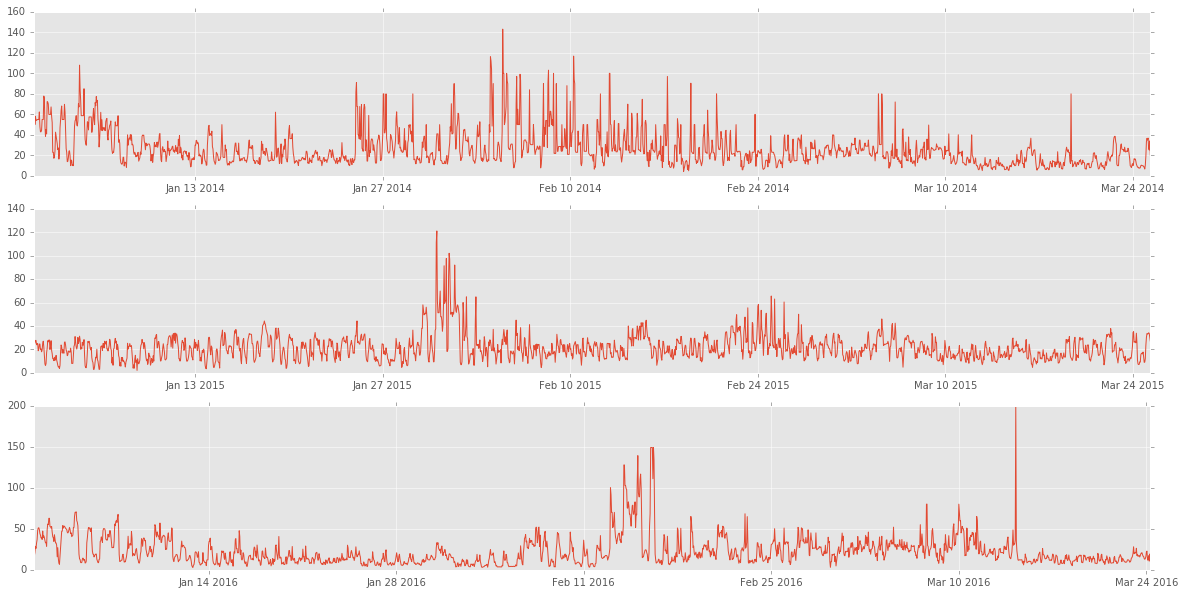

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
    axx.plot(band_price[band_price['year'] == year]['value'].iloc[:2000])

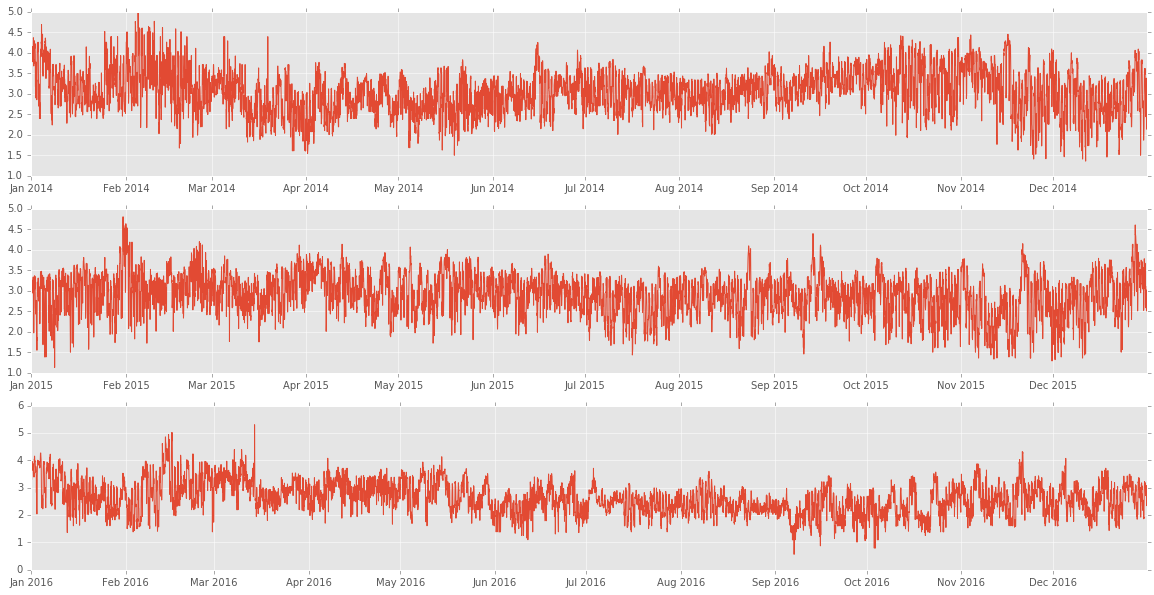

In [37]:
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
    axx.plot(np.log1p(band_price[band_price['year'] == year]['value']))

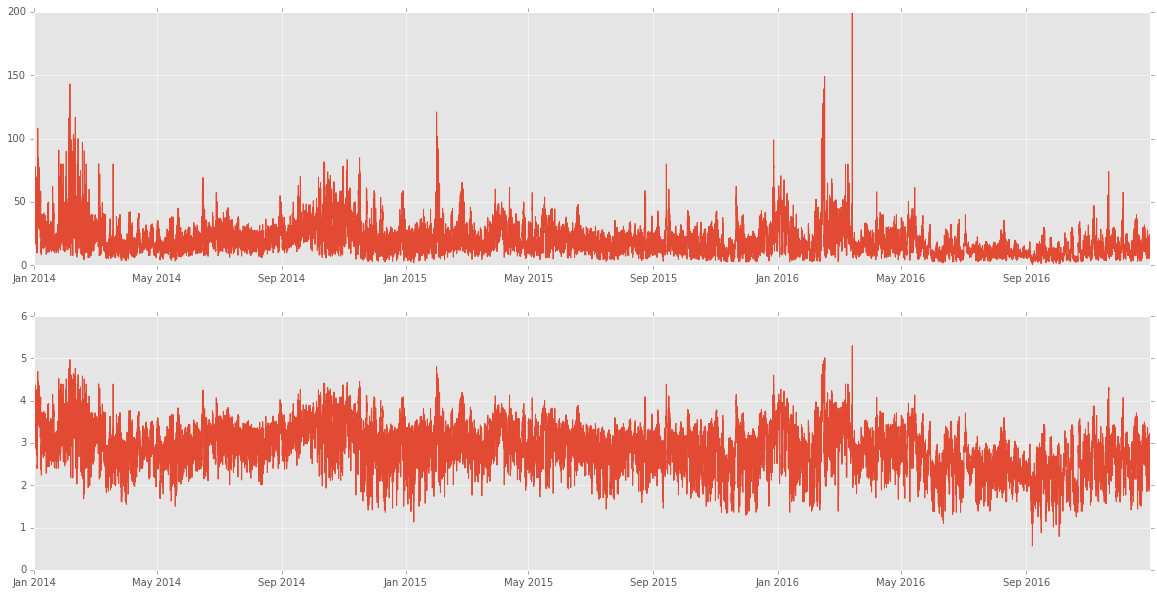

In [38]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
ax0.plot(band_price['value'])
ax1.plot(np.log1p(band_price['value']));

### Heatmap per year, season, weekday and hour

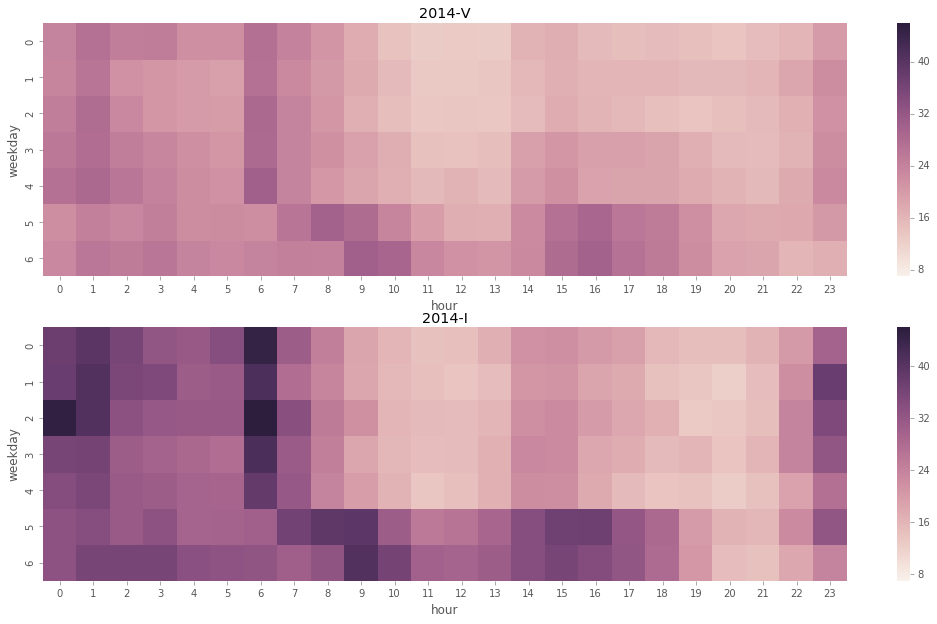

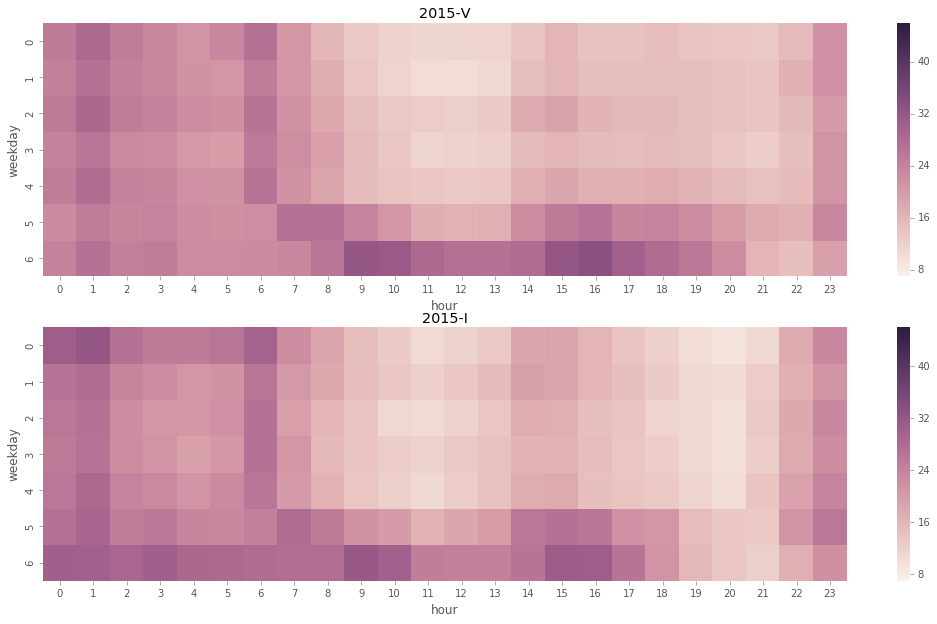

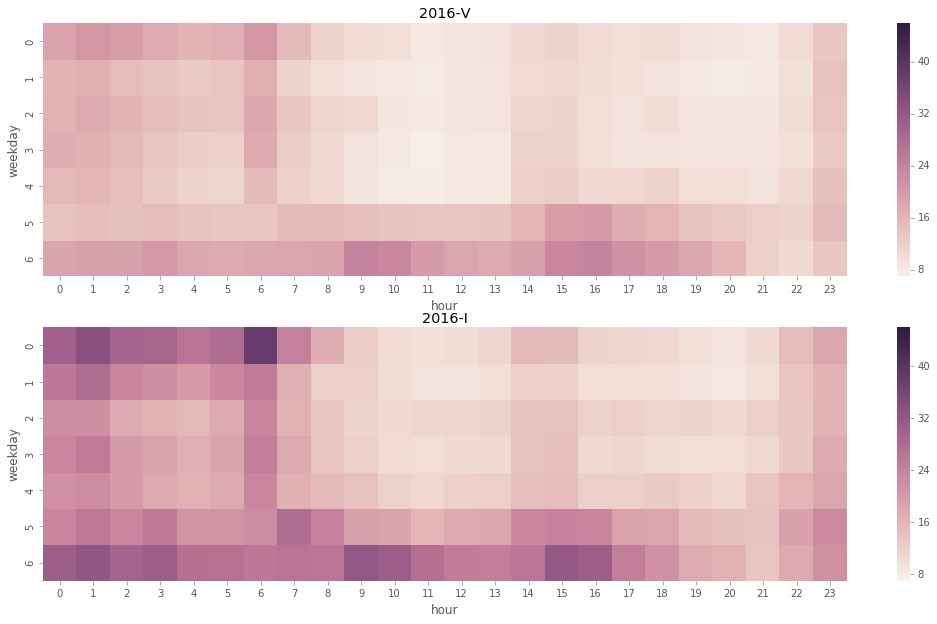

In [39]:
for year in [2014, 2015, 2016]:
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(18,10))
    #Use v_max, vmin to plot with same colors
    for axis, season in zip([ax0, ax1], ['V', 'I']):
        sns.heatmap(year_weekday_hour_band_price.loc[year, season], ax=axis, vmax=46, vmin=7)
        axis.set_title(str(year) + '-' + season)

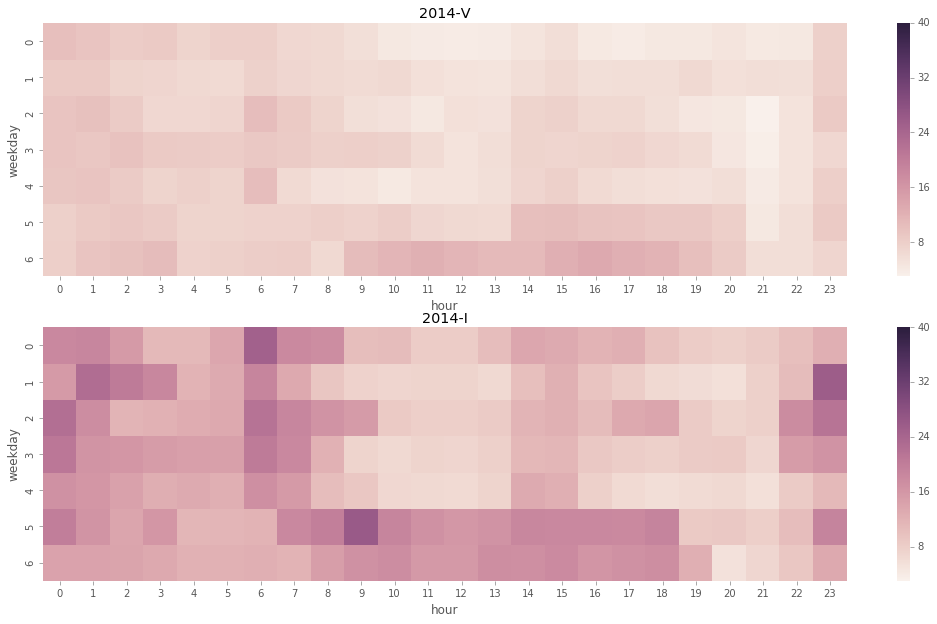

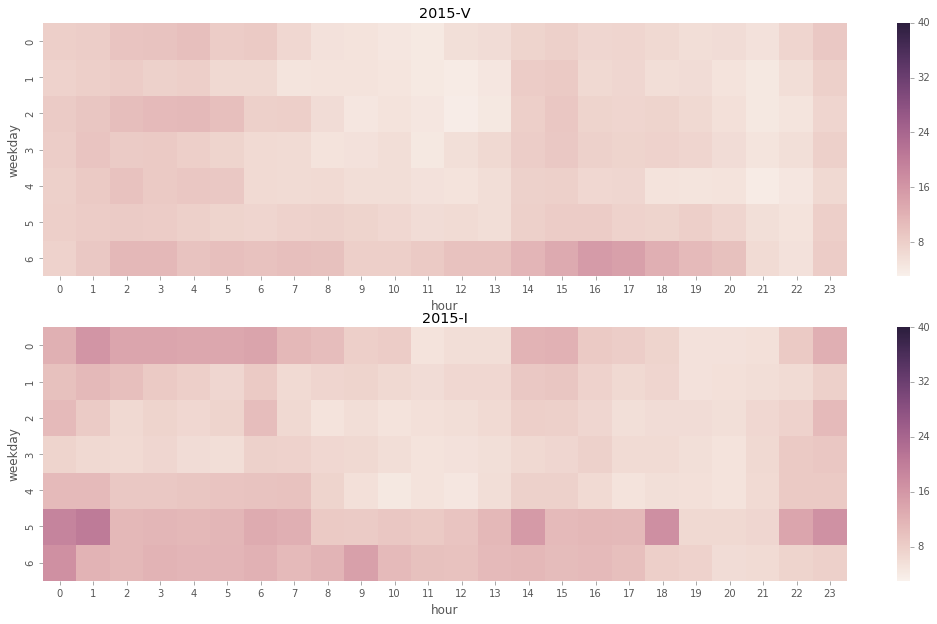

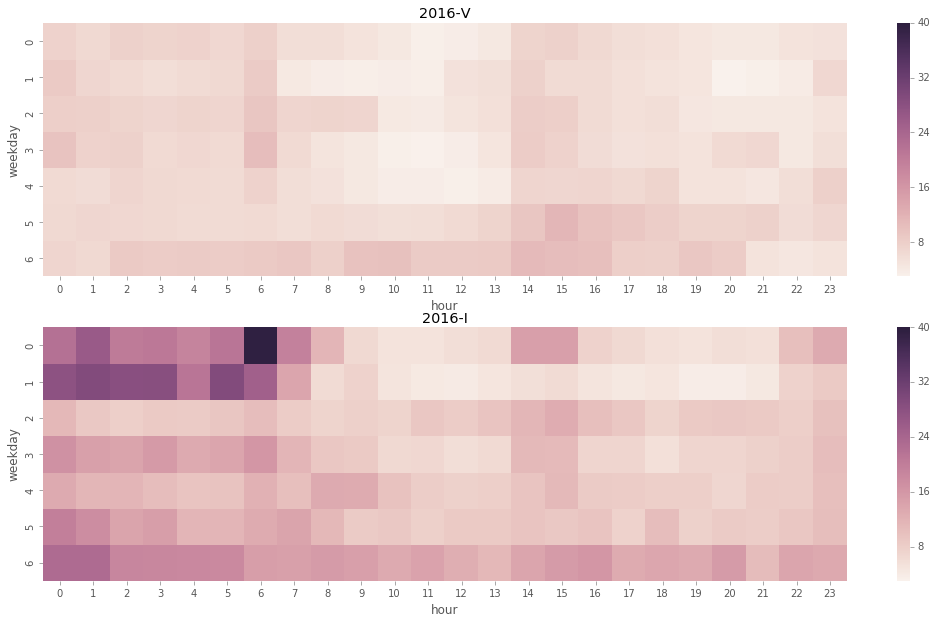

In [40]:
for year in [2014, 2015, 2016]:
    fig, (ax0, ax1) = plt.subplots(2,1, figsize=(18,10))
    #Use v_max, vmin to plot with same colors
    for axis, season in zip([ax0, ax1], ['V', 'I']):
        sns.heatmap(year_weekday_hour_band_price_std.loc[year, season], ax=axis, vmax=40, vmin=3)
        axis.set_title(str(year) + '-' + season)

### Check rolling mean and std by day, week, month

In [41]:
def plot_rolling_mean_std(series, window, ax1, ax2=None):
    #Rolling statistics
    rolmean = pd.rolling_mean(series, window=window)
    rolstd = pd.rolling_std(series, window=window)
    
    label_dict={
            24:'day',
            48:'two-day',
            168:'week',
            720:'month',
            8760:'year'
    }
    
    ax1.plot(rolmean, label=label_dict[window] + '- mean')
    if ax2 != None:
        ax2.plot(rolstd, label=label_dict[window] + '- std')

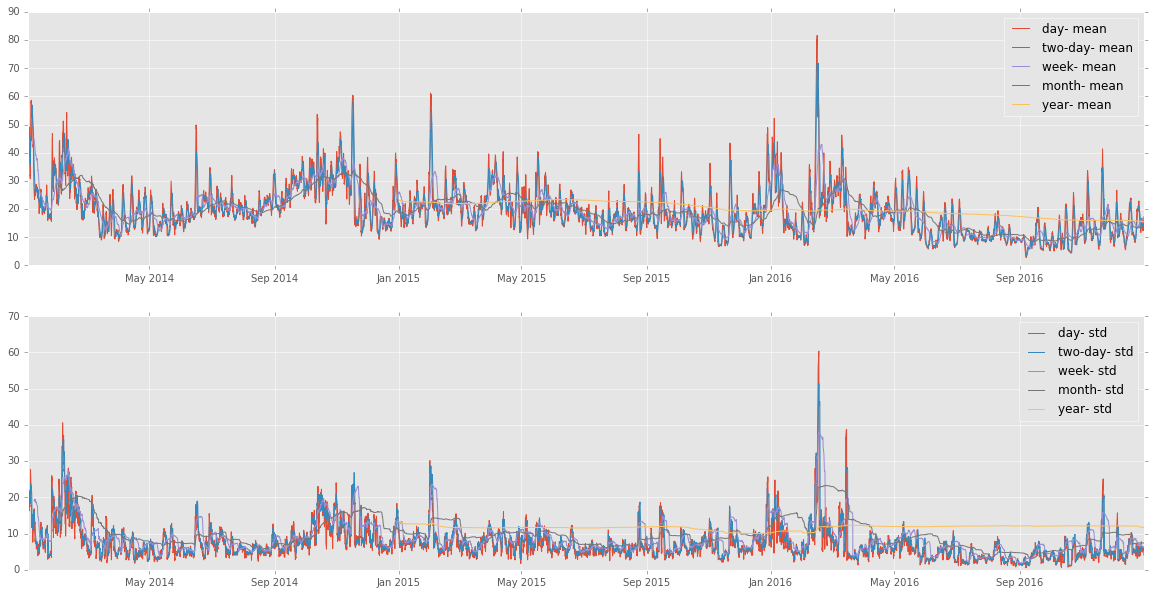

In [42]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
for window in [24, 48, 168, 720, 8760]:
    plot_rolling_mean_std(band_price['value'], window, ax0, ax1)
    ax0.legend(loc='best')
    ax1.legend(loc='best')

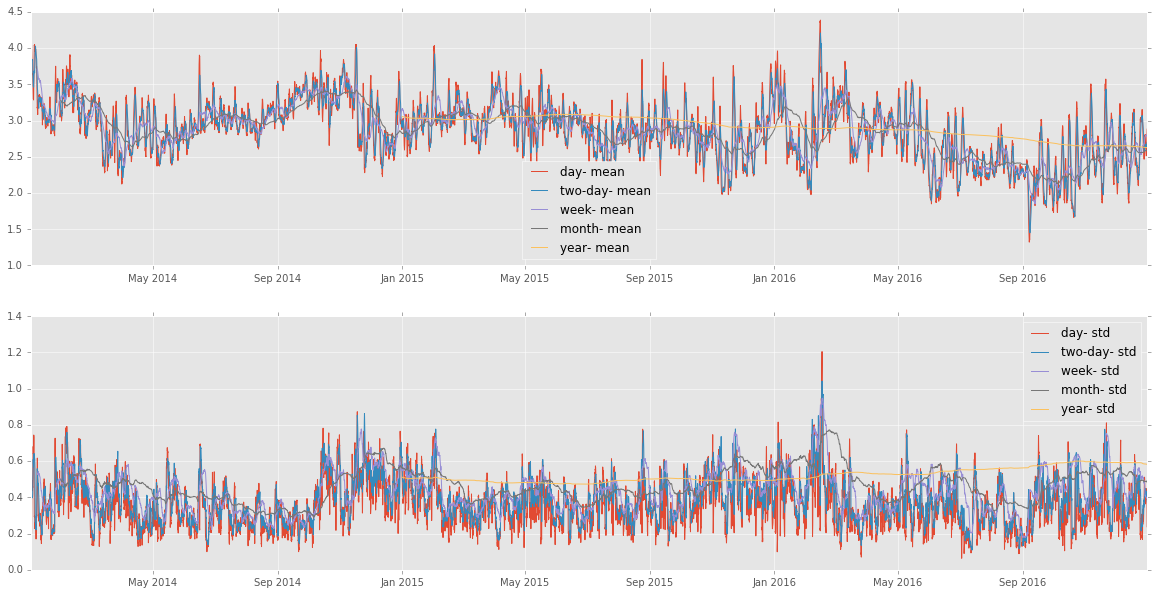

In [43]:
#With log transformation 
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(20,10))
for window in [24, 48, 168, 720, 8760]:
    plot_rolling_mean_std(np.log1p(band_price['value']), window, ax0, ax1)
    ax0.legend(loc='best')
    ax1.legend(loc='best')

In [44]:
def remove_rolling_mean(series, window, ax):
    rolmean=pd.rolling_mean(series, window=window)
    series_rolling_mean_diff = series - rolmean
    label_dict={
            24:'day',
            48:'two-day',
            168:'week',
            720:'month',
            8760:'year'
    }
    ax.plot(series_rolling_mean_diff, label='original minus rolling mean')
    for window_roll in [24, 48, 168, 720, 8760]:
        plot_rolling_mean_std(series_rolling_mean_diff, window_roll, ax)

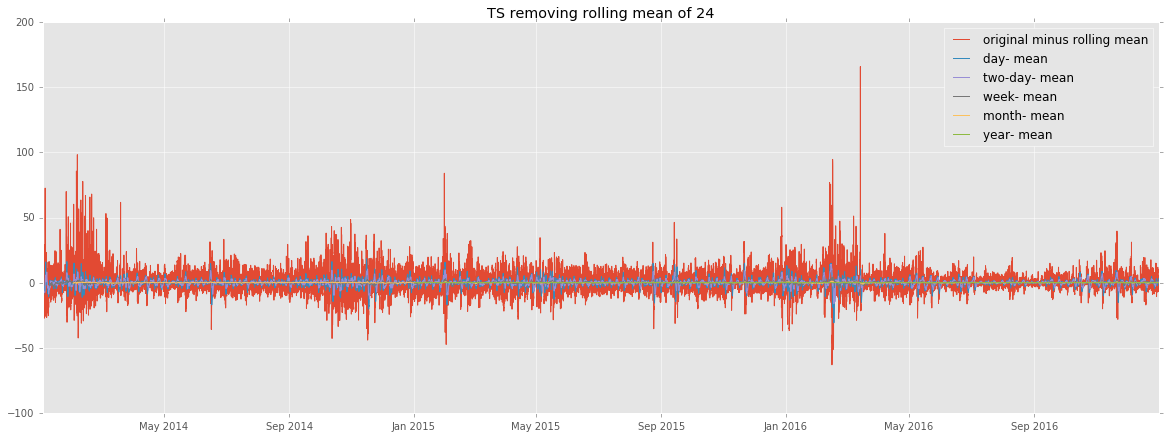

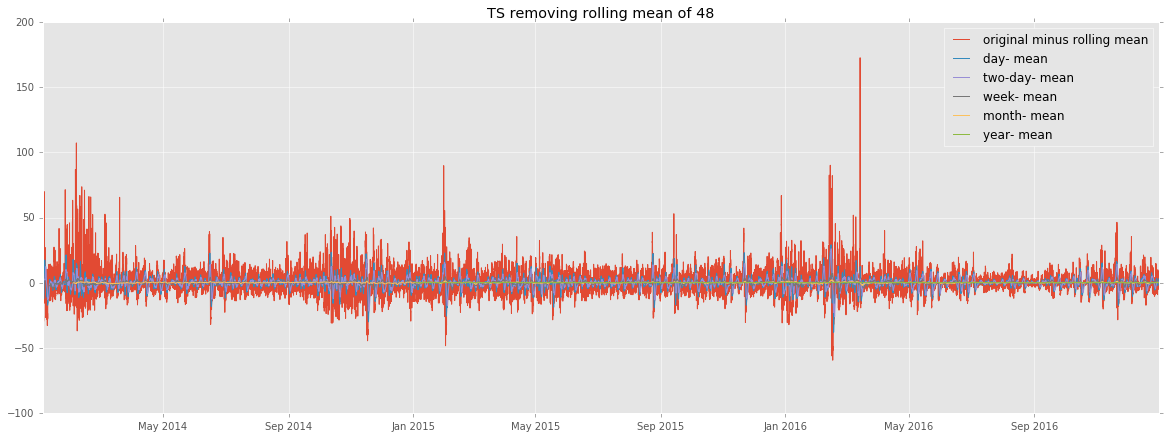

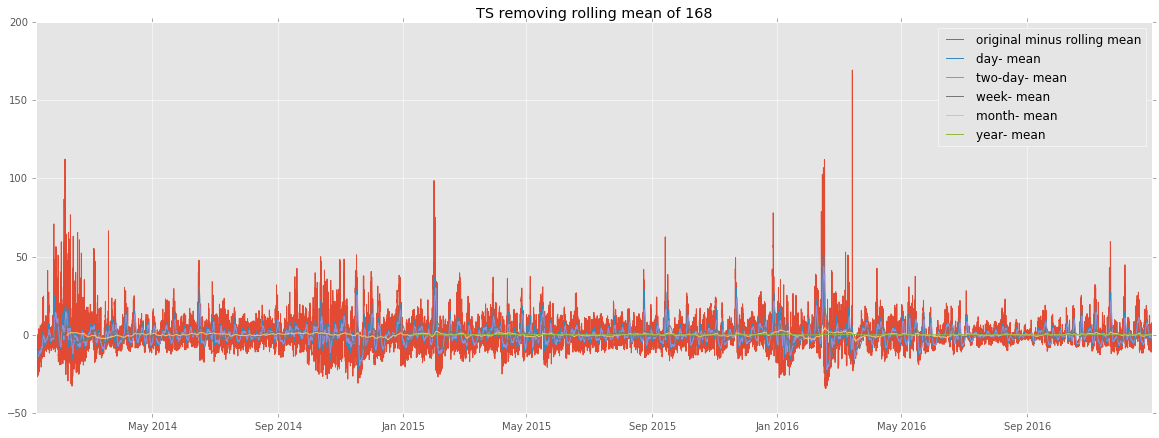

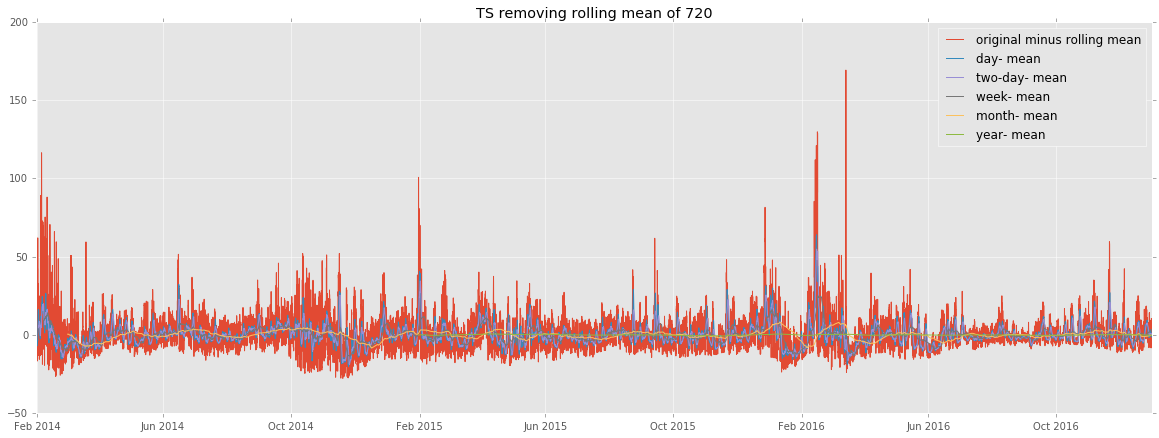

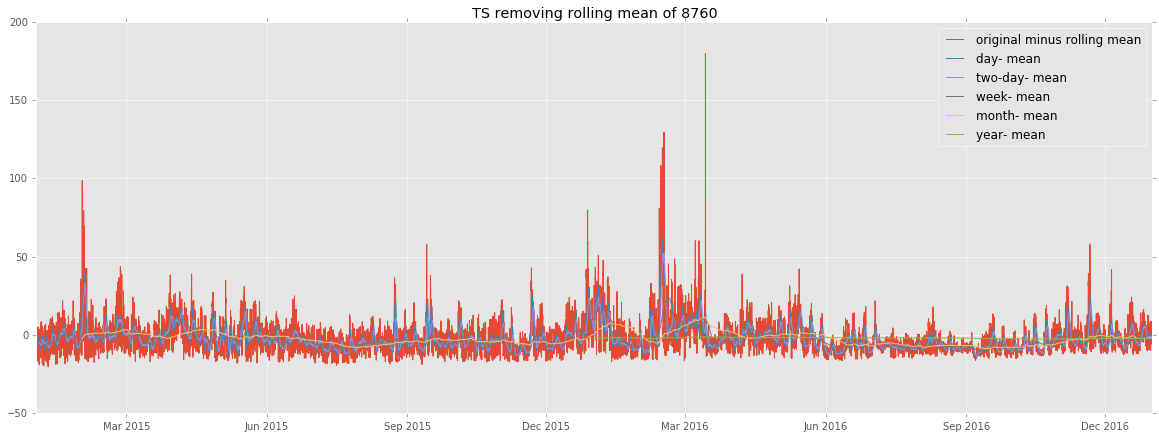

In [45]:
for window in [24, 48, 168, 720, 8760]:
    fig, ax = plt.subplots(1,1, figsize=(20,7))
    remove_rolling_mean(band_price['value'], window, ax)
    ax.legend(loc=0)
    ax.set_title('TS removing rolling mean of ' + str(window))

### Apply log transformation and remove rolling mean of 24 hours

In [46]:
log_band_price = band_price.copy(deep=True)

In [47]:
log_band_price['value'] = np.log1p(log_band_price['value'])

In [48]:
log_band_price['value_rolling_mean_24_diff'] =  log_band_price['value'] - pd.rolling_mean(log_band_price['value'], window=24)

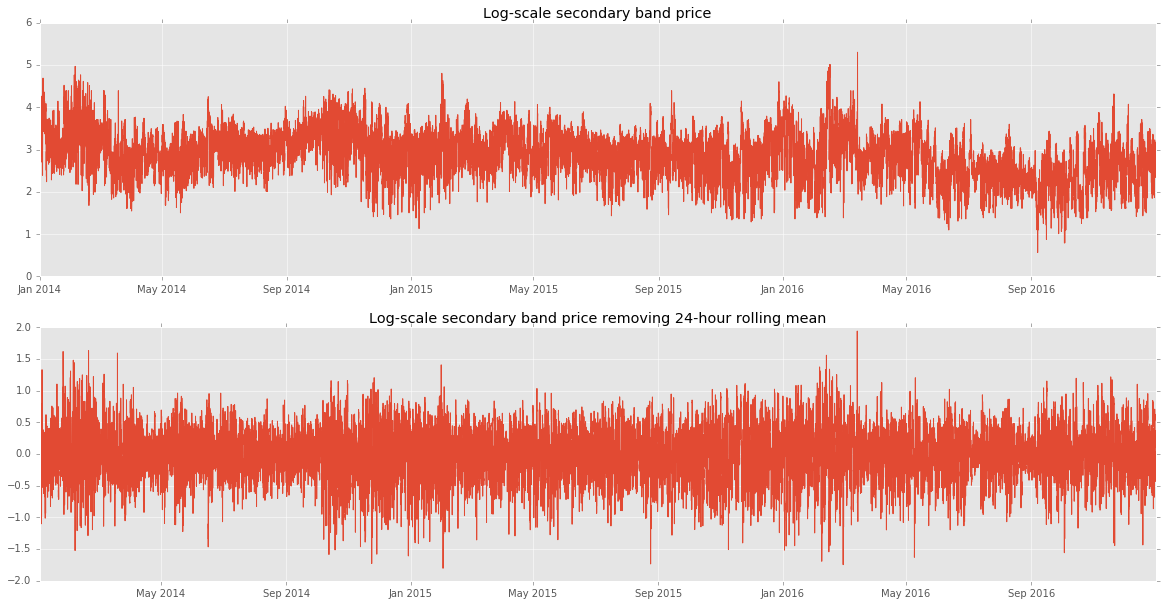

In [49]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['value_rolling_mean_24_diff'])
ax1.set_title('Log-scale secondary band price removing 24-hour rolling mean');

In [50]:
log_band_price['value_ewma_24_hours'] = log_band_price['value'] - pd.ewma(log_band_price['value'], halflife=24)

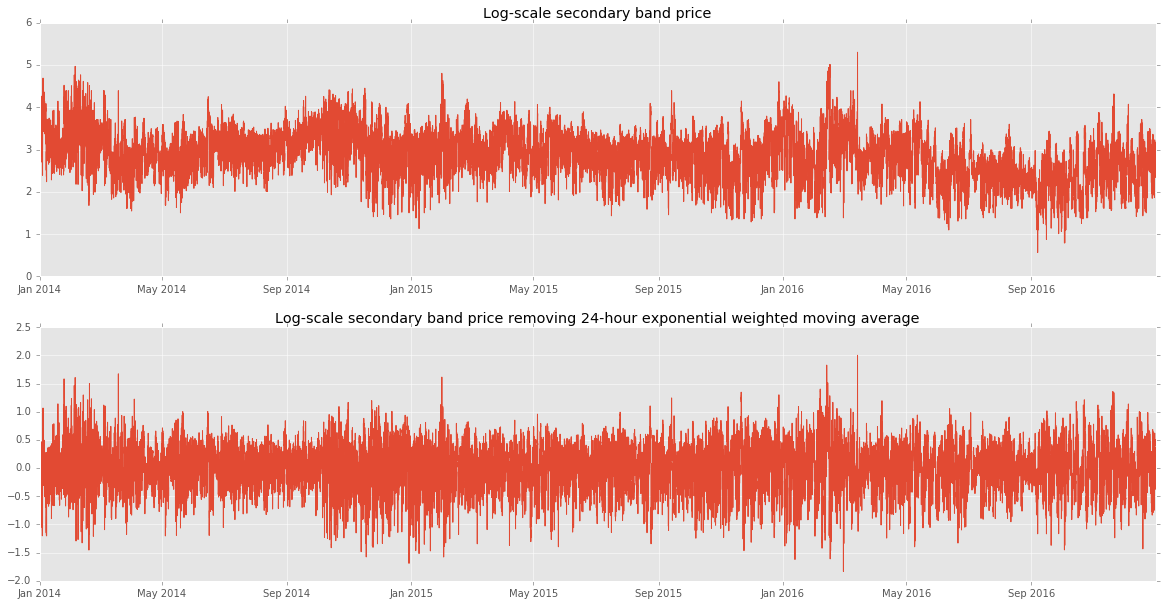

In [51]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['value_ewma_24_hours'])
ax1.set_title('Log-scale secondary band price removing 24-hour exponential weighted moving average');

### Trend and seasonality decomposition

In [52]:
import statsmodels.api as sm

In [53]:
decomposition = sm.tsa.seasonal_decompose(band_price['value'], freq=24)

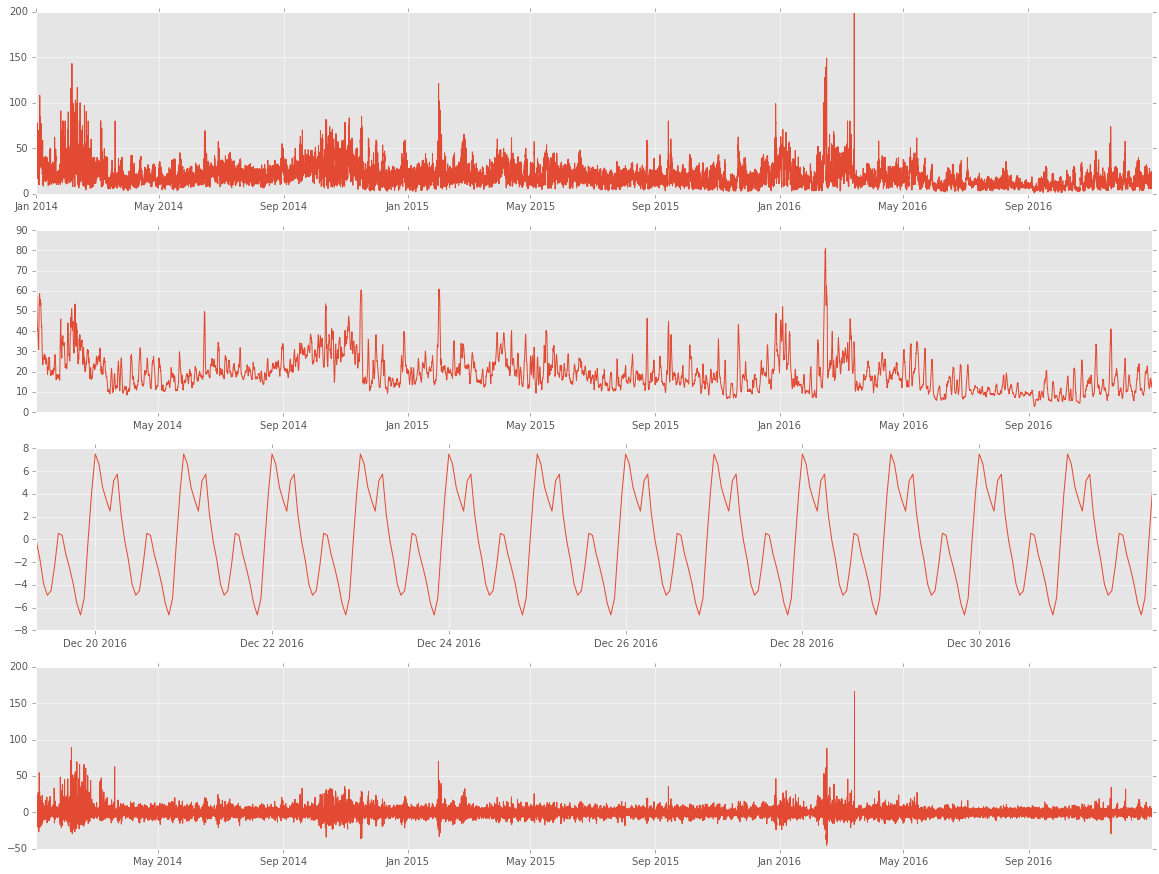

In [54]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(20,15))
ax0.plot(band_price['value'])
ax1.plot(decomposition.trend)
ax2.plot(decomposition.seasonal[26000:])
ax3.plot(decomposition.resid);

### Dick-Fuller test on stationarity

In [55]:
from statsmodels.tsa.stattools import adfuller

In [56]:
def perform_stationarity_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutpout = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags used',
                                             'Number of observation used'])
    for key, value in dftest[4].items():
        dfoutpout['Critical value (%s)'%key] = value
    print(dfoutpout)

In [57]:
perform_stationarity_test(band_price['value'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.238772e+01
p-value                       4.866884e-23
#Lags used                    4.900000e+01
Number of observation used    2.625400e+04
Critical value (5%)          -2.861650e+00
Critical value (10%)         -2.566829e+00
Critical value (1%)          -3.430599e+00
dtype: float64


In [58]:
perform_stationarity_test(log_band_price['value'])

Results of the Dickey-Fuller Test:
Test Statistic               -1.209585e+01
p-value                       2.071544e-22
#Lags used                    4.900000e+01
Number of observation used    2.625400e+04
Critical value (5%)          -2.861650e+00
Critical value (10%)         -2.566829e+00
Critical value (1%)          -3.430599e+00
dtype: float64


In [59]:
perform_stationarity_test(log_band_price['value_rolling_mean_24_diff'].dropna())

Results of the Dickey-Fuller Test:
Test Statistic                  -29.104324
p-value                           0.000000
#Lags used                       49.000000
Number of observation used    26231.000000
Critical value (5%)              -2.861650
Critical value (10%)             -2.566829
Critical value (1%)              -3.430599
dtype: float64


In [60]:
perform_stationarity_test(log_band_price['value_ewma_24_hours'].dropna())

Results of the Dickey-Fuller Test:
Test Statistic                  -24.343209
p-value                           0.000000
#Lags used                       49.000000
Number of observation used    26254.000000
Critical value (5%)              -2.861650
Critical value (10%)             -2.566829
Critical value (1%)              -3.430599
dtype: float64


### ACF and PACF

In [61]:
from statsmodels.tsa.stattools import acf, pacf

In [62]:
def compute_acf_pacf(timeseries, acf_lags, pacf_lags):
    lag_acf = acf(timeseries.dropna(), nlags=acf_lags)
    lag_acf_df = pd.DataFrame(lag_acf, columns=['ACF'])
    lag_acf_df.index.name='Hour'
    
    lag_pacf = pacf(timeseries.dropna(), nlags=pacf_lags)
    lag_pacf_df = pd.DataFrame(lag_pacf, columns=['PACF'])
    lag_pacf_df.index.name = 'Hour'
    
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(20,15))
    lag_acf_df.iloc[:100].plot(kind='bar', ax=ax0)
    ax0.axhline(y=-1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    ax0.axhline(y=+1.96/np.sqrt(len(lag_acf)), linestyle='--', color='blue')
    lag_pacf_df.iloc[:100].plot(kind='bar', ax=ax1);
    ax1.axhline(y=-1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')
    ax1.axhline(y=+1.96/np.sqrt(len(lag_pacf)), linestyle='--', color='blue')

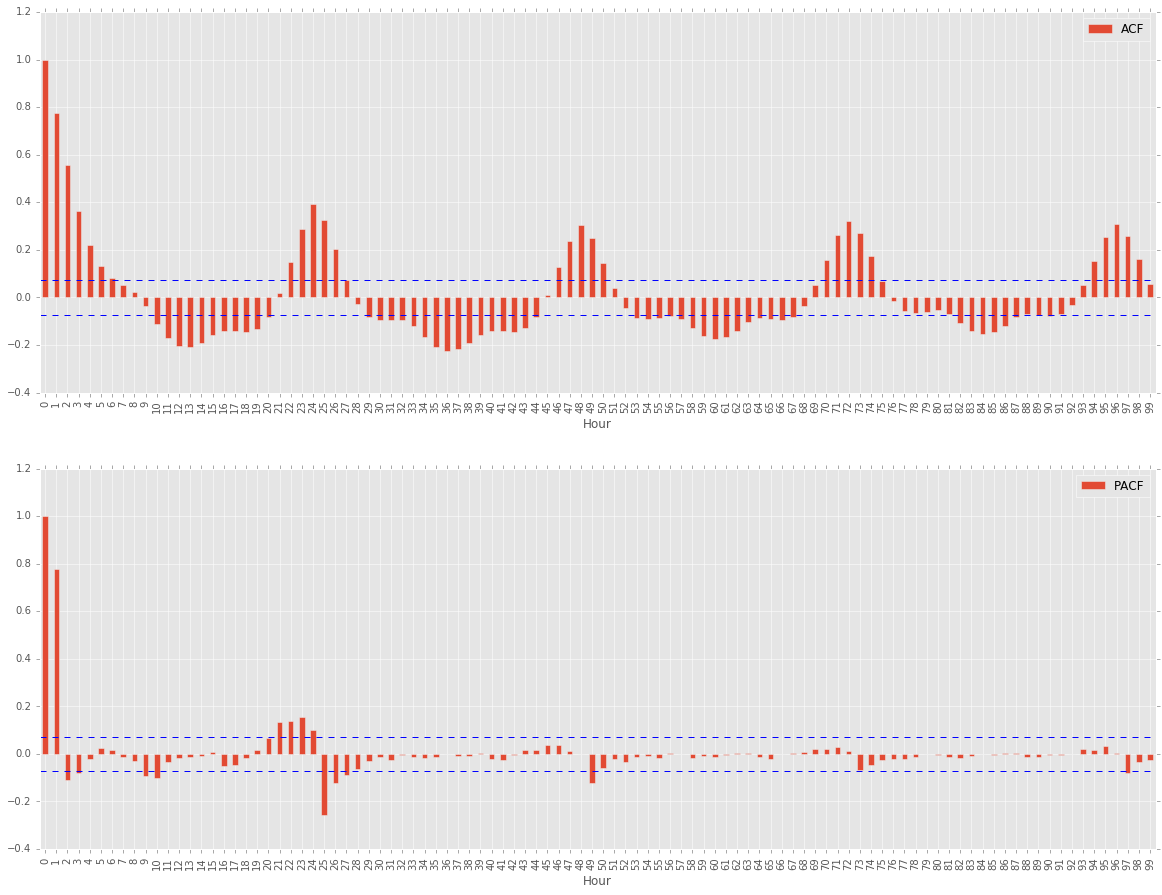

In [63]:
compute_acf_pacf(log_band_price['value_rolling_mean_24_diff'], 720, 720)

In [ ]:
compute_acf_pacf((log_band_price['value']-log_band_price['value'].shift()).dropna(), 720, 720)

In [ ]:
compute_acf_pacf(log_band_price['value_rolling_mean_24_diff'], 170, 170)

### ARIMA Model, p=2; q=5

In [64]:
from statsmodels.tsa.arima_model import ARIMA

In [65]:
def compute_ARIMA_model_plot_residuals(timeseries, p,d,q):
    model = ARIMA(timeseries.dropna(), order=(p,d,q))
    results = model.fit(disp=-1, maxiter=1000)
    
    if d > 0:
        timeseries_diff = timeseries.dropna() - timeseries.dropna().shift(d)
        rss = ((results.fittedvalues - timeseries_diff.dropna())**2).sum()
        return rss, timeseries_diff.dropna(), results.fittedvalues, results
    else:
        rss = ((results.fittedvalues - timeseries.dropna())**2).sum()
        return rss, timeseries.dropna(), results.fittedvalues, results

In [66]:
def plot_original_ts_and_estimated(rss, original, estimated, initial, end):
    fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(20,10))
    for axx, year in zip((ax0, ax1, ax2), [2014, 2015, 2016]):
        axx.plot(original[original.index.year == year].iloc[initial:end])
        axx.plot(estimated[estimated.index.year == year].iloc[initial:end])
    ax0.set_title('RSS: {0:.2f}'.format(rss))

In [67]:
%%time
rss, original_ts, estimated_ts, model = compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 2,0,2)

Wall time: 13.3 s


In [76]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  ARMA Model Results                                  
======================================================================================
Dep. Variable:     value_rolling_mean_24_diff   No. Observations:                26281
Model:                             ARMA(2, 2)   Log Likelihood                -846.766
Method:                               css-mle   S.D. of innovations              0.250
Date:                        Fri, 03 Feb 2017   AIC                           1705.532
Time:                                16:59:43   BIC                           1754.592
Sample:                            01-01-2014   HQIC                          1721.373
                                 - 12-31-2016                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
const                               -0.0005      0.006     -0.085      0.933        -0.012     0.011
ar.L1.value_rolling_mean_24_diff     1.0687      0.044     24.310      0.000         0.983     1.155
ar.L2.value_rolling_mean_24_diff    -0.3017      0.032     -9.404      0.000        -0.365    -0.239
ma.L1.value_rolling_mean_24_diff    -0.2169      0.044     -4.945      0.000        -0.303    -0.131
ma.L2.value_rolling_mean_24_diff     0.0789      0.010      7.570      0.000         0.058     0.099
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7713           -0.4213j            1.8207           -0.0372
AR.2            1.7713           +0.4213j            1.8207            0.0372
MA.1            1.3739           -3.2835j            3.5593           -0.1869
MA.2            1.3739           +3.2835j            3.5593            0.1869
-----------------------------------------------------------------------------
"""

In [77]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: ARMA
================================================================================
Model:                ARMA                       BIC:                 1754.5918 
Dependent Variable:   value_rolling_mean_24_diff Log-Likelihood:      -846.77   
Date:                 2017-02-03 16:59           Scale:               1.0000    
No. Observations:     26281                      Method:              css-mle   
Df Model:             5                          Sample:              01-01-2014
Df Residuals:         26276                                           12-31-2016
Converged:            1.0000                     S.D. of innovations: 0.250     
AIC:                  1705.5322                  HQIC:                1721.373  
--------------------------------------------------------------------------------
                                  Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
--------------------------------------------------------------------------------
const                            -0.0005   0.0057 -0.0846 0.9326 -0.0117  0.0107
ar.L1.value_rolling_mean_24_diff  1.0687   0.0440 24.3101 0.0000  0.9825  1.1548
ar.L2.value_rolling_mean_24_diff -0.3017   0.0321 -9.4039 0.0000 -0.3645 -0.2388
ma.L1.value_rolling_mean_24_diff -0.2169   0.0439 -4.9452 0.0000 -0.3029 -0.1309
ma.L2.value_rolling_mean_24_diff  0.0789   0.0104  7.5699 0.0000  0.0585  0.0994
---------------------------------------------------------------------------------------------
                     Real               Imaginary              Modulus              Frequency
---------------------------------------------------------------------------------------------
AR.1                1.7713                -0.4213               1.8207                -0.0372
AR.2                1.7713                 0.4213               1.8207                 0.0372
MA.1                1.3739                -3.2835               3.5593                -0.1869
MA.2                1.3739                 3.2835               3.5593                 0.1869
================================================================================

"""

In [71]:
alpha = model.arparams

In [72]:
theta = model.maparams

In [73]:
alpha

array([ 1.06867294, -0.30166625])

In [ ]:
np.random.seed(1000)
def gen_sn(M, I):
    sn = np.random.standard_normal((M+1, I/2))
    sn = np.concatenate((sn, -sn), axis=1)
    sn = (sn - sn.mean()) / sn.std()
    return sn

In [ ]:
rand = gen_sn(241, 10000)

In [ ]:
rand.shape

In [ ]:
rand[0]

In [ ]:
S = np.zeros((242, 10000))

In [ ]:
S[0] = 28
S[1] = 20

In [ ]:
alpha

In [ ]:
theta

In [ ]:
for t in range(2, 242):
    S[t] = alpha[0] * S[t-1] + alpha[1] * S[t-2] + rand[t] + theta[0] * rand[t-1] + theta[1] * rand[t-2]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.plot(np.exp(S[10:, :200]), alpha=0.5)
ax.grid(True);

In [ ]:
plot_original_ts_and_estimated(rss, original_ts, estimated_ts, 7000, 7200)

In [ ]:
rss_2, original_2, estimated_2, model =compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 4,0,7)

In [ ]:
np.sum(((np.exp(original_2) - np.exp(estimated_2))**2))/len(original_2)

In [ ]:
(np.exp(original_2) - np.exp(estimated_2)).iloc[9500:9700].plot(figsize=(20,10))

In [ ]:
log_band_price['value_rolling_mean_24_diff'].dropna().shape

In [ ]:
original_2.head(3)

In [ ]:
estimated_2.head(3)

In [ ]:
plot_original_ts_and_estimated(rss_2, original_2, estimated_2, 0, 168)

In [ ]:
rss_2, original_2, estimated_2 =compute_ARIMA_model_plot_residuals(log_band_price['value_rolling_mean_24_diff'], 4,0,7)

In [ ]:
((((np.exp(original_2) - np.exp(estimated_2))**2)).sum())/len(original_2)

In [ ]:
((((original_2 - estimated_2)**2)).sum())/len(original_2)

In [ ]:
np.exp(original_2).iloc[12000:12020].plot(figsize=(20,10))
np.exp(estimated_2).iloc[12000:12020].plot(figsize=(20,10))

In [ ]:
np.exp(original_2).iloc[12000:12020]

In [ ]:
np.exp(estimated_2).iloc[12000:12020]

In [ ]:
np.exp(estimated_2).iloc[12000:12024]

In [ ]:
plot_original_ts_and_estimated(rss_2, original_2, estimated_2, 8700, 8760)

In [ ]:
log_band_price['prueba'] = pd.rolling_mean(log_band_price['value'].shift(24), window=24)

In [ ]:
log_band_price['prueba_2'] = log_band_price['value'] - log_band_price['prueba']

In [ ]:
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(20,10))
ax0.plot(log_band_price['value'].iloc[24000:25000])
ax0.set_title('Log-scale secondary band price')
ax1.plot(log_band_price['prueba_2'].iloc[24000:25000])
ax1.set_title('Log-scale secondary band price removing 24-hour moving average of d-2');

In [ ]:
perform_stationarity_test(log_band_price['prueba_2'].dropna())

In [ ]:
compute_acf_pacf(log_band_price['prueba_2'], 720, 720)

In [ ]:
a, b,c = compute_ARIMA_model_plot_residuals(log_band_price['prueba_2'], 2, 0, 7)

In [ ]:
a